# AUCを計算する
　この課題はAUCを理解するためのもので, ライブラリを使用するのでなく, 実際にご自身のプログラムでAUCを計算することを目的とします. また, 参考としてPrecision, Recallという指標についても触れます.
 - **課題の前提条件：予測値が重複する(ROC曲線上の点が斜めに移動する)可能性は考慮しなくてよい**
   - 本編第2回でやる決定木などでは予測値は重複し, そのときROC曲線の変化は階段状(長方形)ではなく, 台形になります
   - ここではあくまでAUCの理解が目的なので, 例外処理(台形)は一旦考慮しません
 - 前半はAUCを計算するためのヒントを記載しています
 - 後半にAUC計算の作成課題とPrecision, Recallについての説明を記載しています
 - 末尾に解答例を載せてあります

## Import

In [1]:
import pandas as pd
import numpy as np

# 計算時間の計測
import time

# 可視化ライブラリ
import seaborn as sns
import matplotlib.pyplot as plt

# 検算用のAUC計算ライブラリ
from sklearn.metrics import roc_auc_score

## Setting

In [2]:
# Figure Size
plt.rcParams["figure.figsize"] = (15.0, 10.0)
plt.rcParams["font.size"] = 15

## Make Data
　課題用のデータを擬似的に作成します. 設定は, 危険運転をする人を予測したデータです. **ここで課題用データを作成しているので, 必ず実行してください.**
 - これは**擬似的に作るデータ**です
 - 各変数の意味
  - y:目的変数で危険運転をした人は1, 通常の運転をした人は0が入っています
  - pred:とある予測モデルが算出した危険運転をする確率となります

In [3]:
### ここのセルのプログラムは理解しなくても良いです
def make_predict(x):
    if x==1:
        y = np.random.normal(loc=0.6, scale=0.1, size=1)[0]
    else:
        y = np.random.normal(loc=0.4, scale=0.1, size=1)[0]
    y = max(min(y, 1), 0)
    return y

np.random.seed(seed=17)
dat = pd.DataFrame()
dat["y"] = np.random.choice(a=[1,0], size=50000, p=[1/10, 9/10])
dat["pred"] = dat["y"].apply(make_predict)

　データを確認してみましょう.

In [4]:
dat.head()

,y,pred
0,0,0.552671
1,0,0.331018
2,0,0.447690
3,1,0.709084
4,0,0.308230


In [5]:
dat.shape

(50000, 2)

In [6]:
# 危険運転率
dat["y"].mean()

0.10012

In [7]:
dat["pred"].max()

1.0

In [8]:
dat["pred"].min()

0.0

## AUCを計算する準備：ROC曲線
　まずは視覚的にpredの分布がy=1, 0でどのくらい差があるのかを確認し, 次に**データをまたぐ閾値ごとに, 真陽性率と偽陽性率を計算してみます.** 最後に計算した真陽性率と偽陽性率をもとにROC曲線を描いてみます.
 - ポイント
  - **配布資料(モデルの精度評価資料.pdf)の体重データにあたるのが, 今回はpred(モデル予測値)となります**
  - モデル予測値が高いほど危険運転の割合が高くなります

### 分布の確認
　y=0, 1でどれくらいpred(モデル予測値)が違うのか確認してみましょう.

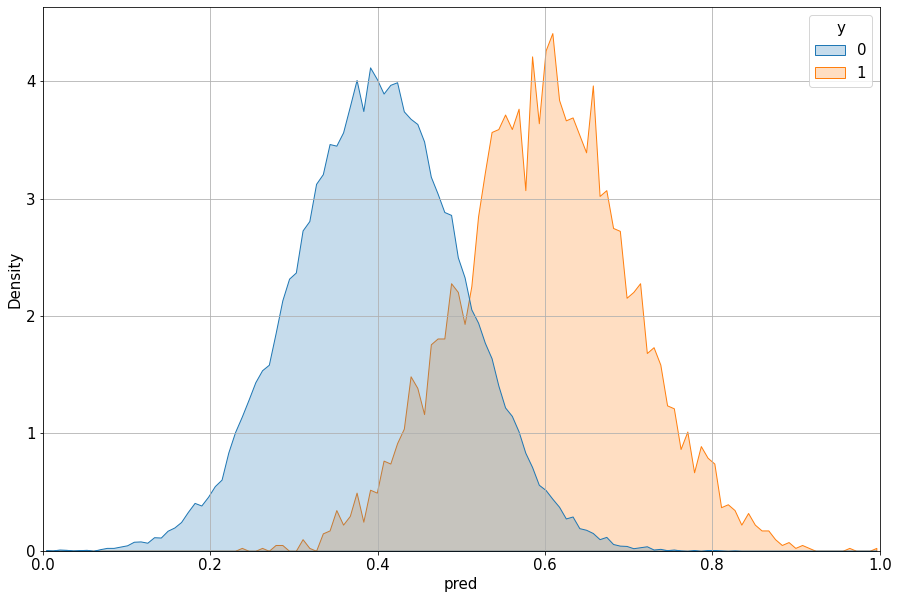

In [9]:
sns.histplot(
    dat, x="pred", hue="y", element="poly", stat="density", common_norm=False).set(xlim=(0, 1))
plt.grid()

　重なり合っている部分がありますが, ある程度綺麗に分かれていることが分かりました.
### 真陽性率と偽陽性率の計算
　今回は, 閾値をpredの最大値から下げていき, 閾値以上の場合に「危険運転をした」, 閾値未満の場合に「通常運転をした」と予測したとして,
 - 真陽性率 = 実際に危険運転をした人の内, 「危険運転をした」と正しく予測できた割合
 - 偽陽性率 = 実際は通常運転をした人の内, 「危険運転をした」と間違って予測してしまった割合

となります. このとき, **閾値がデータを1つまたいだ時に真陽性率と偽陽性率のどちらかが変化するので, 閾値として予測値自体を利用します.** なぜなら, 閾値 **「以上」** を「危険運転をした」と予測するので, 閾値として予測値を利用して良い分けです.    
　今回は, 2つの計算方法を参考として載せます.
 - 方法1：for文で愚直に計算する
   - ROC曲線のための真陽性率と偽陽性率の計算を理解するのが目的です
 - 方法2：工夫して計算し, 計算時間を高速化する
   - 既存のライブラリを使わない目的の1つでもある「高速化」を実現するためのものです
 - 共通で大事なポイント
   - **pred(モデル予測値)の大きい順に並べ替えるのを忘れないように！**
     - 上のグラフの1から0まで閾値を変化させたときの真陽性率と偽陽性率の計算をしたいからです

In [10]:
%%time
##### 方法1：分かりやすいが計算速度が遅いやり方
# predの大きい順(降順)にデータを並べ替え
ROC_1 = dat.sort_values("pred", ascending=False)

# 各閾値で計算した真陽性率と偽陽性率を格納するリスト
tp_rate = []
fp_rate = []

# 累積されるTP(実際に予測通りy=1であったデータ数)
tp = 0

# 累積されるFP(実際は予測と違いy=0であったデータ数)
fp = 0

# 実際にy=1の件数
tp_all = ROC_1[ROC_1["y"]==1].shape[0]

# 実際にy=0の件数
fp_all = ROC_1[ROC_1["y"]==0].shape[0]

# DataFrameを上から1行ずつ行名をindex, 行をrowに代入して最終行までループします
# つまり閾値を順番に下げていることになります(predの値で降順に並べ替えている場合)
for index, row in ROC_1.iterrows():
    
    # row.yはyの値を取り出している
    if row.y == 1:
        # 閾値以上の正しく予測できた件数(y=1の数)を加算
        tp = tp + 1
    else:
        # 閾値以上の間違って予測してしまった件数(y=0の件数)を加算
        fp = fp + 1
    
    # 真陽性率を閾値ごとにリストに格納する
    tp_rate = tp_rate + [tp / tp_all]
    
    # 偽陽性率を閾値ごとにリストに格納する
    fp_rate = fp_rate + [fp / fp_all]

# DataFrameに列追加
ROC_1["tp_rate"] = tp_rate
ROC_1["fp_rate"] = fp_rate

Wall time: 10.3 s


　この資料を作成した環境では計算に**約10秒**掛かりました.

In [11]:
# データ確認：先頭10行
ROC_1.head(10)

,y,pred,tp_rate,fp_rate
35640,1,1.000000,0.000200,0.0
38271,1,0.964984,0.000400,0.0
22473,1,0.917551,0.000599,0.0
8213,1,0.906928,0.000799,0.0
33232,1,0.905862,0.000999,0.0
19046,1,0.895647,0.001199,0.0
4490,1,0.894280,0.001398,0.0
31081,1,0.891910,0.001598,0.0
36876,1,0.887383,0.001798,0.0
12727,1,0.880598,0.001998,0.0


In [12]:
# データ確認：末尾10行
ROC_1.tail(10)

,y,pred,tp_rate,fp_rate
32276,0,0.031477,1.0,0.999800
18732,0,0.027084,1.0,0.999822
35279,0,0.024852,1.0,0.999844
4289,0,0.019268,1.0,0.999867
49535,0,0.017449,1.0,0.999889
17138,0,0.016622,1.0,0.999911
37203,0,0.016155,1.0,0.999933
6599,0,0.013225,1.0,0.999956
10806,0,0.006244,1.0,0.999978
2852,0,0.000000,1.0,1.000000


In [13]:
%%time
##### 方法2：工夫して高速で計算する方法
# predの大きい順(降順)にデータを並べ替え
ROC_2 = dat.sort_values("pred", ascending=False)

# 累積和cumsumを使って一気に真陽性率を閾値ごとに計算
ROC_2["tp_rate"] = ROC_2["y"].cumsum() / ROC_2["y"].sum()
ROC_2["fp_rate"] = (ROC_2["y"] == 0).cumsum() / (ROC_2["y"]==0).sum()

Wall time: 7.98 ms


　この資料を作成した環境では計算に**約0.01秒**掛かりました.

In [14]:
# データ確認：先頭10行
ROC_2.head(10)

,y,pred,tp_rate,fp_rate
35640,1,1.000000,0.000200,0.0
38271,1,0.964984,0.000400,0.0
22473,1,0.917551,0.000599,0.0
8213,1,0.906928,0.000799,0.0
33232,1,0.905862,0.000999,0.0
19046,1,0.895647,0.001199,0.0
4490,1,0.894280,0.001398,0.0
31081,1,0.891910,0.001598,0.0
36876,1,0.887383,0.001798,0.0
12727,1,0.880598,0.001998,0.0


In [15]:
# データ確認：末尾10行
ROC_2.tail(10)

,y,pred,tp_rate,fp_rate
32276,0,0.031477,1.0,0.999800
18732,0,0.027084,1.0,0.999822
35279,0,0.024852,1.0,0.999844
4289,0,0.019268,1.0,0.999867
49535,0,0.017449,1.0,0.999889
17138,0,0.016622,1.0,0.999911
37203,0,0.016155,1.0,0.999933
6599,0,0.013225,1.0,0.999956
10806,0,0.006244,1.0,0.999978
2852,0,0.000000,1.0,1.000000


In [16]:
# データが等しいことを確認
ROC_1.equals(ROC_2)

True

### ROC曲線を描く
　ROC曲線は横軸が偽陽性率, 縦軸が真陽性率でした.

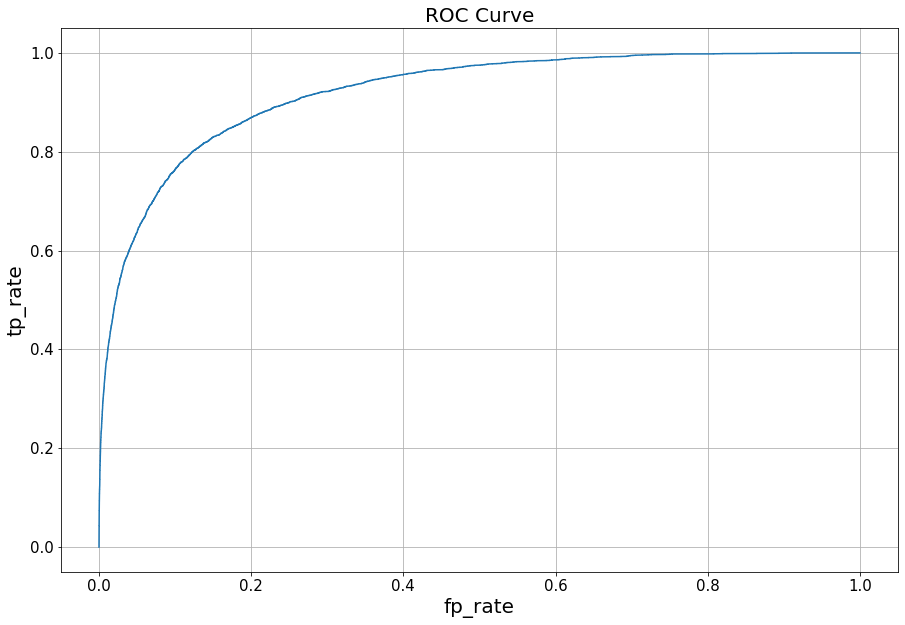

In [17]:
plt.plot(ROC_1["fp_rate"], ROC_1["tp_rate"])
plt.title("ROC Curve", fontsize=20)
plt.xlabel("fp_rate", fontsize=20)
plt.ylabel("tp_rate", fontsize=20)
plt.grid()

## AUCを計算する準備：面積の計算
　今回は有限個のデータですので, 階段状にROC曲線が描かれています. 横軸の偽陽性率は**y=0のデータが来るたびに一定の値増加します,** つまりy=0の行が来るたびに横幅 = 1/(データ全体のy=0の件数), 高さ = その時の真陽性率の長方形を加算すれば良い分けです.  
　参考例として, 次の曲線の面積を計算してみます.
 - **ヒント：縦軸が増加したフラグ(increase_flag)はROC_1のデータではyと一致し, 0の時に横軸方向に増加する**

In [18]:
area = pd.DataFrame()
# 縦軸が増加したフラグ
area["increase_flag"] = [1, 1, 1, 0, 1, 0, 1, 0, 0, 0]

area["X"] = [0, 0, 0, 0.2, 0.2, 0.4, 0.4, 0.6, 0.8, 1]
area["Y"] = [0.2, 0.4, 0.6, 0.6, 0.8, 0.8, 1, 1, 1, 1]

In [19]:
# データ確認
area

,increase_flag,X,Y
0,1,0.0,0.2
1,1,0.0,0.4
2,1,0.0,0.6
3,0,0.2,0.6
4,1,0.2,0.8
5,0,0.4,0.8
6,1,0.4,1.0
7,0,0.6,1.0
8,0,0.8,1.0
9,0,1.0,1.0


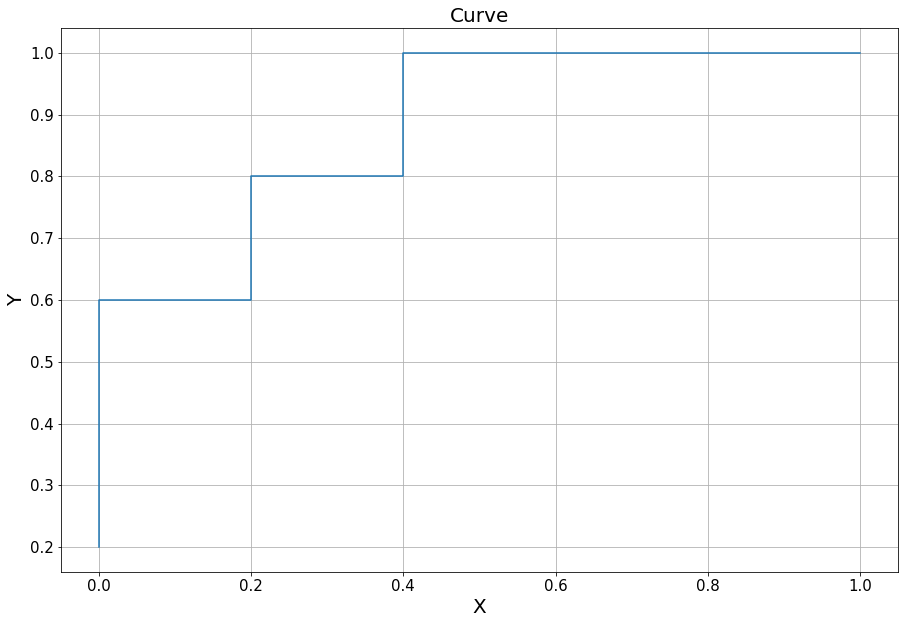

In [20]:
plt.plot(area["X"], area["Y"])
plt.title("Curve", fontsize=20)
plt.xlabel("X", fontsize=20)
plt.ylabel("Y", fontsize=20)
plt.grid()

In [21]:
# 面積の計算
ans = 0
# 横幅
width = 1 / sum(area["increase_flag"] == 0)
for index, row in area.iterrows():
    # グラフが横に移動するごとに追加される長方形の面積を加算していく
    if row.increase_flag == 0:
        # 高さ
        height = row.Y
        # 長方形の面積を加算
        ans = ans + width * height
        
        print("X:" + str(row.X) + ", Y: " + str(row.Y) + ", width: " + str(width) + ", height: " + str(height))

print("面積：" + str(ans))

X:0.2, Y: 0.6, width: 0.2, height: 0.6
X:0.4, Y: 0.8, width: 0.2, height: 0.8
X:0.6, Y: 1.0, width: 0.2, height: 1.0
X:0.8, Y: 1.0, width: 0.2, height: 1.0
X:1.0, Y: 1.0, width: 0.2, height: 1.0
面積：0.8800000000000001


## 課題：AUCを計算する
　擬似的に作ったデータdatのyが目的変数, predが予測値としてAUCを計算する課題です. まずはAUCを計算できるようになるために, 1に取り組んでください. AUCを理解する(自分で計算する)という観点ではここまでで大丈夫です. 実際に利用するときには計算速度を早くする必要があるので, 2の工夫して計算する方法に取り組んでみてください. また, Pythonで関数の作成の仕方を知っている方は, せっかくですので関数として作成してみましょう.  
**※課題の解答例はこのNotebookの最後に載せてあります, 最初は見ないで自分で考えてみましょう**
 1. すでに真陽性率と偽陽性率が計算されているROC_1を用いて, AUCを計算してみて下さい
   - 上記の面積の計算例のプログラムを書き換えることで, 計算できます
   - ROC_1を作成するための, 真陽性率と偽陽性率の計算については理解している前提としています
     - **真陽性率と偽陽性率の計算について理解してから取り組んでください**
 2. 工夫して計算し, AUCを計算する速度を早くする
   - このとき, datから計算するプログラムにしましょう
 3. 関数化する
   - 引数はお任せしますが, こだわりが無ければ引数はdat["y"]とda["pred"]で作成してみて下さい

In [22]:
# 検算用にAUCを既存のライブラリで計算する
roc_auc_score(dat["y"], dat["pred"])

0.9195429368830835

In [23]:
##### 解答欄：1

In [24]:
##### 解答欄：2

In [25]:
##### 解答欄：3

## 参考：PrecisionとRecall
　予測モデルを実際のビジネスに応用するときに良く使う指標として, PrecisionとRecallがあります. この指標について追加で参考として解説します.  
**※ここで出てくるビジネスに関する設定は全て説明のためのフィクションです**  
 
　AUCを計算する過程で出てきた真陽性率と偽陽性率が登場した時に, 混同行列(Confusion Matrix)というものが出てきました. 混同行列の値を使用した指標例として, 配布した「モデルの精度評価資料.pdf」の補足資料にPrecisionとRecallの定義が記載されていますが, 一般化されて定義しているので, $p^*_{all}$という分かりにくい用語が使われています, 今回は分かりやすく下記で**改めてPrecisionとRecallを定義します.**  
　さて, 今回わざわざ擬似的に危険運転の予測をするデータを作成したのは, このPrecisionとRecallを説明するためです. 今回の危険運転予測の例でPrecisionとRecallを定義すると下記の様になります.
 - **Precision：危険運転をすると予測した人の内, 実際に危険運転をする人の割合**
 - **Recall：実際に危険運転をする人の内, 危険運転をすると予測できた人の割合**
   - このとき, データ上に全ての危険運転をする人のデータがあるとしています
   - または, データに記録される危険運転する人のみを危険運転者の対象としているとも考えられます
 - Precisionのことを適合率, Recallのことを再現率といいます
 
この2つはトレードオフの関係で, **一方を高めようとするともう一方が低くなる関係**にあります.  
　それでは, 今回のデータ例でPrecisionとRecallについて見ていきましょう. 今回, 予測値は**危険運転をする確率**でした. つまり**この予測モデルで危険運転者を抽出する時には, 予測値に対して閾値を決めて閾値以上であれば危険運転者**とする必要があるわけです. **閾値を変えると危険運転者と予測する数も変わってきます**. では, まず危険運転確率が**0.5**を超えたときに危険運転者とすると

In [26]:
# Precision：危険運転をすると予測した人の内, 実際に危険運転をする人の割合
dat[dat["pred"] > 0.5]["y"].mean()

0.3699601240584847

In [27]:
# Recall：実際に危険運転をする人の内, 危険運転をすると予測できた人の割合
dat[dat["pred"] > 0.5]["y"].sum() / dat["y"].sum()

0.8339992009588494

　上記の計算結果の様に, Precisionは**約37%**, Recallは**約83%** となりました(※実行環境によって数値が少し変わることがあります). 皆さんは, 予測モデルを作成したら, それで終わりでなく**ビジネスに使う**はずです. このとき, この予測結果をそのままビジネスに使えるでしょうか？もちろん問題設定によります. 例えば, 皆さんの会社が今回の危険運転を行う人を予測するAIを作成したので, 警察に対して, このAIを使用すると交通課の仕事を省くために使えると売り込んだとしましょう. このとき, AIが危険運転者だと予測したら自動的に違反切符を切って罰金を科すとすると, とんでもないことになってしまいます. いま, Recallは約83%なので自動で8割も違反者を捕まえるのはすごい！となりますが, Precisionが約37%なので, 予測モデルが捕まえた人の4割は確かに違反者ですが, **残りの6割は危険運転をしていない善良な市民**です. とてもじゃないですが, これでは使い物にはなりません. では, 危険運転確率が**0.99**を超えたときに危険運転者とすると

In [28]:
# Precision：危険運転をすると予測した人の内, 実際に危険運転をする人の割合
dat[dat["pred"] > 0.99]["y"].mean()

1.0

In [29]:
# Recall：実際に危険運転をする人の内, 危険運転をすると予測できた人の割合
dat[dat["pred"] > 0.99]["y"].sum() / dat["y"].sum()

0.00019976028765481422

　今回は, Precisionが**100%** でRecallが**約0.02%** です. 確かに, 危険運転者として捕まえた人は100%間違いなく実際に危険運転者ですが, **実際の危険運転者の99.98%は見逃してしまっている**ことになります. このAIは間違えませんが, 甘々な判定です. これもとてもじゃないですが, 使い物になりません. では, 閾値を変化させるとPrecisionとRecallはどのような値を取るか見てみましょう.

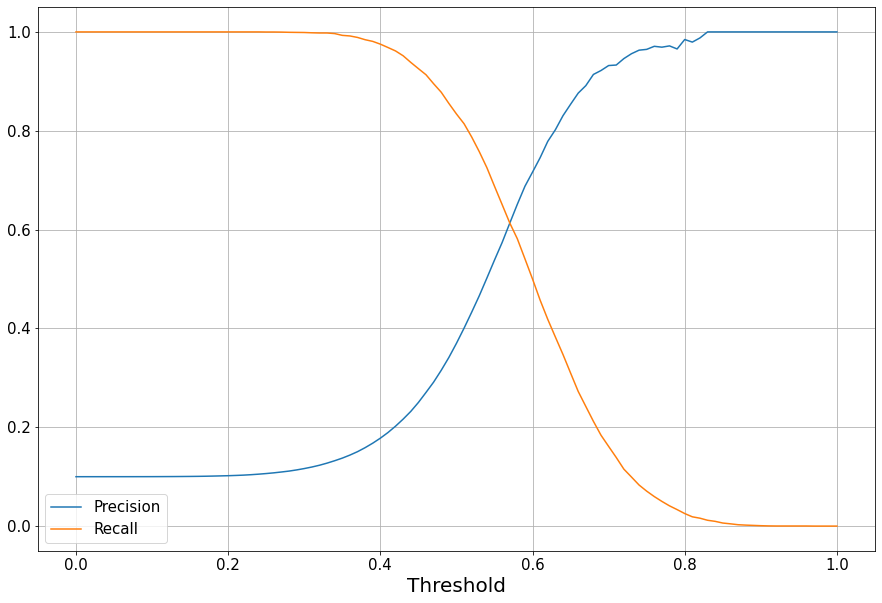

In [30]:
### Precision, Recallのグラフ作成
pre = []
rec = []
th = []
N_rate = []
N_all = dat.shape[0]
P = dat["y"].sum()
for i in range(101):
    tmp = dat[dat["pred"] >= i/100].copy()
    tp = tmp[tmp["y"]==1].shape[0]
    fp = tmp[tmp["y"]==0].shape[0]
    fn = P - tp
    pre += [tp/(tp+fp)]
    rec += [tp/(tp+fn)]
    th += [i/100]
    N_rate += [tmp.shape[0] / N_all]

table = pd.DataFrame()
table["Precision"] = pre
table["Recall"] = rec
table["N_rate"] = N_rate
table.index = th

table[["Precision", "Recall"]].plot()
plt.xlabel("Threshold", fontsize=20)
plt.grid()

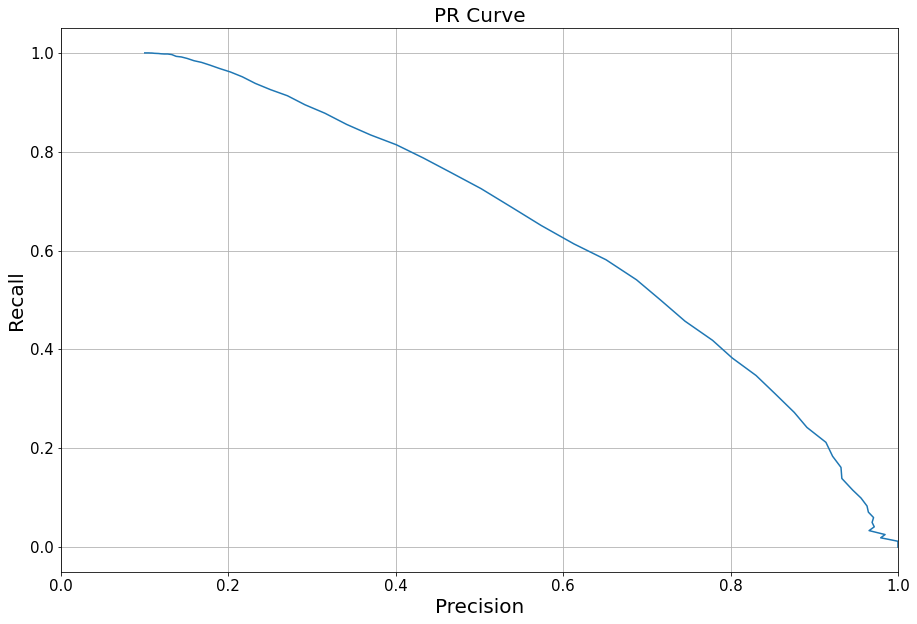

In [31]:
plt.plot(table["Precision"], table["Recall"])
plt.title("PR Curve", fontsize=20)
plt.xlabel("Precision", fontsize=20)
plt.ylabel("Recall", fontsize=20)
plt.xlim(0,1)
plt.grid()

　上記の2つのグラフで, 閾値を変えたときのPrecisionとRecallの値と, PrecisionとRecallの関係が確認できました.  
 
　さて, ではビジネスの話に戻すと, 落としどころを見つけなければなりません. 警察で, 検挙に利用するとなると予測ミスは許されません. Precisionは100%が絶対で, Recallも90%以上(少しの見逃しは許容できる)は必要です. この問題設定では, 今回の精度では無理でしょう.
 
　では, 損害保険会社で自動審査としてこのAIを利用して, 現状全て人間が書類審査して自動車保険に加入して大丈夫か判断しているものを自動化することはどうでしょうか？  
 
　損害保険会社の担当者にヒアリングすると, 一定数は事故を起こす前提で保険は作られているため, AIによる自動審査で実際に危険運転者の何割かは入ってきても許容できるとのことでした(**※フィクションです**). ただし, 契約者を少なくはしたくないので, 危険運転をする可能性が高い集団に対しては**人間が今まで通り審査**をしてその中にいる通常運転を行う人は今まで通り審査を通したいとのことでした. したがって, **Recallと目検割合(N_rate)がポイントになります.**  
　では, Recallと目検割合の関係を確認してみましょう.
 - 日本全体の危険運転者の分布(学習データ)と, 自動車保険に申し込む人の危険運転者の分布は変わらないものとします
 - 危険運転確率が, ある閾値以上の人は人間が今まで通り目検審査をする
 - 危険運転確率が, ある閾値未満の人は自動的に審査を通過する

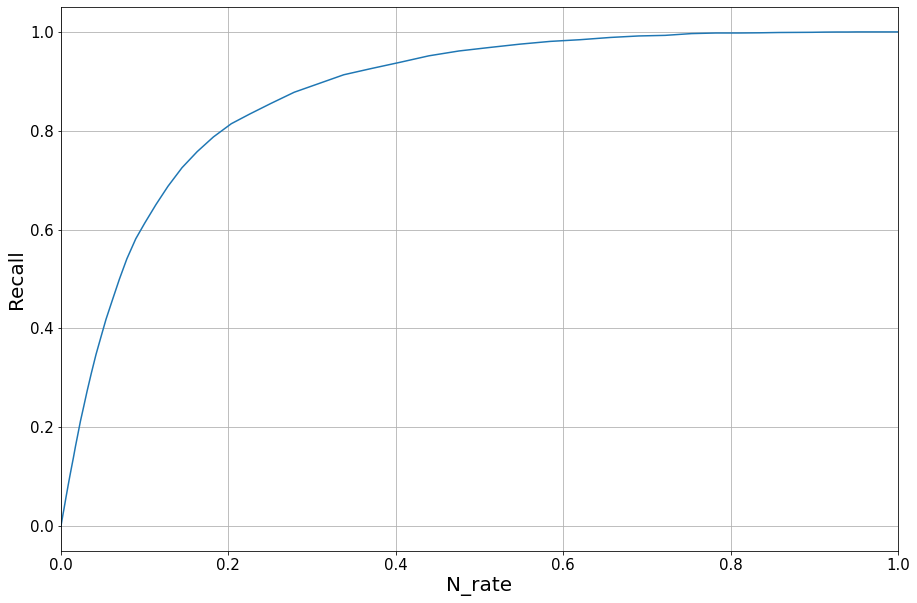

In [32]:
plt.plot(table["N_rate"], table["Recall"])
plt.xlabel("N_rate", fontsize=20)
plt.ylabel("Recall", fontsize=20)
plt.xlim(0,1)
plt.grid()

　上のグラフからRecallを約80%(つまり危険運転者の約2割はAI自動審査を通過する)のを許容すると, 目検率(N_rate)を現状の約20%(人件費を80%カット)にできることが分かる. または, Recallを約90%(つまり危険運転者の約1割はAI自動審査を通過する)のを許容すると, 目検率(N_rate)を現状の約40%(人件費を60%カット)にできる.  
　後はどの塩梅を使用するかで損害保険会社と調整すれば, 皆さんの作成した危険運転予測AIは無事リリースして, AIのビジネス活用を達成するかもしれません.  

　このようにして, PrecisionとRecallは予測モデルを評価したり, 使用したりする上で重要な指標となっています. 特に実際に**予測モデルを使う際に, 意思決定者とのやりとりで重要となることが多い指標**です.

## 課題：AUCを計算する(解答例)

In [33]:
%%time

# 検算用にAUCを既存のライブラリで計算する
roc_auc_score(dat["y"], dat["pred"])

Wall time: 8.98 ms


0.9195429368830835

　この資料の実行環境では計算に**約0.009秒**掛かりました.

1. ROC_1を利用して, AUCの計算(愚直にfor文使用)

In [34]:
%%time

# 面積の計算
ans = 0
# 横幅
width = 1 / sum(ROC_1["y"] == 0)
for index, row in ROC_1.iterrows():
    # グラフが横に移動するごとに追加される長方形の面積を加算していく
    if row.y == 0:
        # 高さ
        height = row.tp_rate
        # 長方形の面積を加算
        ans = ans + width * height

print("AUC：" + str(ans))

AUC：0.9195429368832562
Wall time: 2.37 s


　この資料の実行環境では計算に**約2秒**掛かりました. ライブラリとは小数第13位まで一致したことを確認しました.

　2, 3を合わせて解答.

In [35]:
# AUC計算関数の定義
def calculate_auc_fun(y, pred):
    # 行列化
    y = y.values
    pred = pred.values
    
    # predの大きい順にyを並べ替え
    y = y[np.argsort(-pred)]
    
    # 真陽性率
    tp_rate = np.cumsum(y) / np.sum(y)
    
    # 偽陽性率
    fp_rate = np.cumsum(y == 0) / np.sum(y == 0)
    
    # 偽陽性率が増加したとき以外は真陽性率を0とする
    tp_rate = tp_rate * ((y == 0) + 0)
    
    # AUC
    auc = 0
    width = 1 / np.sum(y == 0)
    auc = np.sum(width * tp_rate)
    
    return auc

In [36]:
%%time

# AUC計算の実行
calculate_auc_fun(dat["y"], dat["pred"])

Wall time: 2.99 ms


0.9195429368830835

　この資料の実行環境では計算に**約0.003秒**掛かりました. ライブラリとは小数第16位まで一致したことを確認しました.